In [32]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

from tqdm import tqdm
from srgan import generator, discriminator
from PIL import Image

physical_devices = tf.config.experimental.list_physical_devices('GPU')
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
weights_dir = '/home/dl/1_study/0_BSU/master_thesis/weights/srgan/'
weights_file = lambda filename: os.path.join(weights_dir, filename)

In [4]:
def load_image(path):
    return np.array(Image.open(path))

def resolve_single(model, lr):
    return resolve(model, tf.expand_dims(lr, axis=0))[0]


def resolve(model, lr_batch):
    lr_batch = tf.cast(lr_batch, tf.float32)
    sr_batch = model(lr_batch)
    sr_batch = tf.clip_by_value(sr_batch, 0, 255)
    sr_batch = tf.round(sr_batch)
    sr_batch = tf.cast(sr_batch, tf.uint8)
    return sr_batch

In [21]:
pre_generator = generator(num_res_blocks=16)
pre_generator.load_weights(weights_file('pre_generator.h5'))
pre_generator.summary()

gan_generator = generator(num_res_blocks=16)
gan_generator.load_weights(weights_file('gan_generator.h5'))
gan_generator.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_37 (Conv2D)              (None, None, None, 6 15616       lambda_4[0][0]                   
__________________________________________________________________________________________________
p_re_lu_19 (PReLU)              (None, None, None, 6 64          conv2d_37[0][0]                  
_______________________________________________________________________________________

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
lambda_8 (Lambda)               (None, None, None, 3 0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_74 (Conv2D)              (None, None, None, 6 15616       lambda_8[0][0]                   
__________________________________________________________________________________________________
p_re_lu_38 (PReLU)              (None, None, None, 6 64          conv2d_74[0][0]                  
_______________________________________________________________________________________

fps:  10.72245826622696
(32, 32, 3)
(128, 128, 3)
(128, 128, 3)


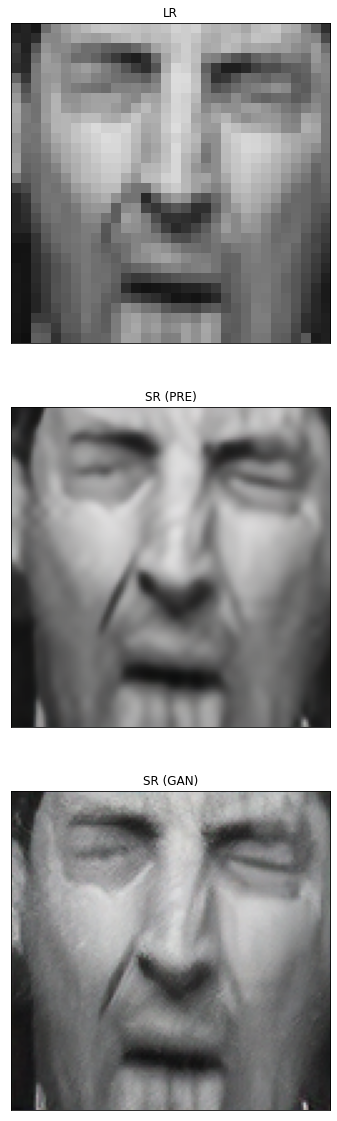

In [28]:
lr = load_image("/home/dl/1_study/0_BSU/master_thesis/dataset/emotions/base/fer2013/preprocess/crop/private_test/disgust/32332_fer_2013.jpg")
# lr = cv2.cvtColor(lr, cv2.COLOR_GRAY2RGB)
lr = cv2.resize(lr, (32, 32))

time_1 = time.time()
pre_sr = resolve_single(pre_generator, lr)
gan_sr = resolve_single(gan_generator, lr)
print("fps: ", 1 / (time.time()-time_1))
print(lr.shape)
print(pre_sr.shape)
print(gan_sr.shape)
plt.figure(figsize=(20, 20))

# pre_sr = cv2.cvtColor(np.array(pre_sr), cv2.COLOR_RGB2GRAY)
images = [lr, pre_sr, gan_sr]
titles = ['LR', 'SR (PRE)', 'SR (GAN)']
positions = [1, 2, 3]

for i, (img, title, pos) in enumerate(zip(images, titles, positions)):
    plt.subplot(3, 1, pos)
    plt.imshow(img)
    plt.title(title)
    plt.xticks([])
    plt.yticks([])

In [29]:
path = "/home/dl/1_study/0_BSU/master_thesis/dataset/emotions/base/"
dataset_1 = "fer2013" 
dataset_2 = "jaffedbase"
dataset_3 = "KDEF_and_AKDEF"
color = (200, 160, 75)

# fer2013

In [30]:
folder_train = "train"
folder_public_test = "public_test"
folder_private_test = "private_test"

In [34]:
for folder_name in [folder_train, folder_public_test, folder_private_test]:
    for emotion in os.listdir(os.path.join(path, dataset_1, "preprocess", "crop", folder_name)):
        for img_name in tqdm(os.listdir(os.path.join(path, dataset_1, "preprocess", "crop", folder_name, emotion))):
            img_crop = load_image(os.path.join(path, dataset_1, "preprocess", "crop", folder_name, emotion, img_name))
            img_dwrp = load_image(os.path.join(path, dataset_1, "preprocess", "dewarp", folder_name, emotion, img_name))
            
            img_crop = cv2.resize(img_crop, (32, 32))
            img_dwrp = cv2.resize(img_dwrp, (32, 32))
            
            gan_sr_crop = resolve_single(gan_generator, img_crop)
            gan_sr_dwrp = resolve_single(gan_generator, img_dwrp)
            
            cv2.imwrite(os.path.join(path, dataset_1, "upscale", "crop", folder_name,
                                     emotion, img_name), 
                        np.array(gan_sr_crop))
            
            cv2.imwrite(os.path.join(path, dataset_1, "upscale", "dewarp", folder_name,
                                     emotion, img_name), 
                        np.array(gan_sr_dwrp))
            

100%|██████████| 474/474 [00:31<00:00, 15.08it/s]


# jaffedbase/KDEF

In [36]:
for emotion in os.listdir(os.path.join(path, dataset_3, "preprocess", "crop")):
    for img_name in tqdm(os.listdir(os.path.join(path, dataset_3, "preprocess", "crop", emotion))):
        
        img_crop = load_image(os.path.join(path, dataset_3, "preprocess", "crop", emotion, img_name))
        img_dwrp = load_image(os.path.join(path, dataset_3, "preprocess", "dewarp", emotion, img_name))

        img_crop = cv2.resize(img_crop, (32, 32))
        img_dwrp = cv2.resize(img_dwrp, (32, 32))

        gan_sr_crop = resolve_single(gan_generator, img_crop)
        gan_sr_dwrp = resolve_single(gan_generator, img_dwrp)

        cv2.imwrite(os.path.join(path, dataset_3, "upscale", "crop",
                                 emotion, img_name), 
                    np.array(gan_sr_crop))

        cv2.imwrite(os.path.join(path, dataset_3, "upscale", "dewarp",
                                 emotion, img_name), 
                    np.array(gan_sr_dwrp))

100%|██████████| 700/700 [00:48<00:00, 14.32it/s]
